In [127]:
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

sys.path.append("./")
sys.path.append("../")

from sbi import utils
from utils import create_mask as cm
from models.scd import dnds

In [128]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [129]:
def dnds_conv(s_ary, theta, ps_temp, roi_counts_normalize, roi_normalize):
    dnds_ary = dnds(s_ary, [1] + list(theta[1:]))
    A = theta[0] / np.trapz(s_ary * dnds_ary, s_ary) / np.mean(ps_temp[~roi_counts_normalize]) ** 2 * np.mean(ps_temp[~roi_normalize])
    dnds_ary = dnds(s_ary, [A] + list(theta[1:]))
    return dnds_ary

In [183]:
roi_mask_norm = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)
roi_normalize = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)
ps_temp = np.load("../data/fermi_data/template_gce.npy")
fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")
s_f_conv = np.mean(fermi_exp[~roi_mask_norm])
pixarea_deg = hp.nside2pixarea(hp.npix2nside(len(fermi_exp)), degrees=True)

In [250]:
# gce, dsk PS priors
prior_ps = [[0.001, 10.0, 1.1, -10.0, 1.0, 0.1], 
            [2.5, 20.0, 1.99, 1.99, 30.0, 0.99]]

In [251]:
from utils.templates import get_NFW2_template
roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)
temp_gce[~roi_normalize_temps].mean()
temp_gce = hp.reorder(temp_gce, r2n=True)

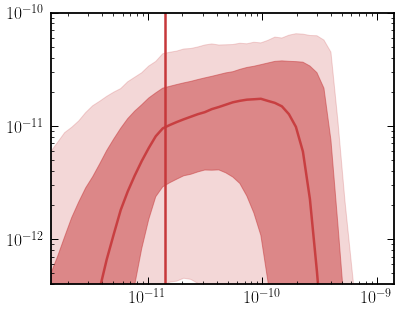

In [252]:
samples = np.random.uniform(prior_ps[0], prior_ps[1], size=(2000, len(prior_ps[0])))
s_ary = np.logspace(-1, 2)
dnds_samples = (s_ary / s_f_conv) ** 2 * np.array([dnds_conv(s_ary, samples[i, :], temp_gce, roi_mask_norm, roi_normalize) for i in range(len(samples))]) * (s_f_conv / pixarea_deg)
plt.plot(s_ary / s_f_conv, np.median(dnds_samples, axis=0), color=cols_default[0])
plt.fill_between(s_ary / s_f_conv, np.percentile(dnds_samples, axis=0, q=[2.5])[0], np.percentile(dnds_samples, axis=0, q=[97.5])[0], alpha=0.2, color=cols_default[0])
plt.fill_between(s_ary / s_f_conv, np.percentile(dnds_samples, axis=0, q=[16])[0], np.percentile(dnds_samples, axis=0, q=[84])[0], alpha=0.5, color=cols_default[0])
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-1 / s_f_conv, 1e2 / s_f_conv)
plt.ylim(4e-13, 1e-10)
plt.axvline(1 / s_f_conv)